## notebook to set up Slingshot workflow

- last updated: 03/27/2024

- reference: https://bioconductor.org/packages/devel/bioc/vignettes/slingshot/inst/doc/vignette.html

### Description: 
This vignette will demonstrate a full single-cell lineage analysis workflow, with particular emphasis on the processes of lineage reconstruction and pseudotime inference. We will make use of the slingshot package proposed in (Street et al. 2017) and show how it may be applied in a broad range of settings.

The goal of slingshot is to use clusters of cells to uncover global structure and convert this structure into smooth lineages represented by one-dimensional variables, called “pseudotime.” We provide tools for learning cluster relationships in an unsupervised or semi-supervised manner and constructing smooth curves representing each lineage, along with visualization methods for each step.

### Overview
The minimal input to slingshot is a matrix representing the cells in a reduced-dimensional space and a vector of cluster labels. With these two inputs, we then:

Identify the global lineage structure by constructing an minimum spanning tree (MST) on the clusters, with the getLineages function.
Construct smooth lineages and infer pseudotime variables by fitting simultaneous principal curves with the getCurves function.
Assess the output of each step with built-in visualization tools.

In [1]:
library(SingleCellExperiment)
library(uwot)
library(mclust, quietly = TRUE)
library(slingshot, quietly = FALSE)
library(dplyr)

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

In [2]:
library(Seurat)
library(Signac)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.

Attaching SeuratObject


Attaching package: ‘Seurat’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays




In [3]:
multiome <- readRDS("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_RNA_ATAC.rds")
multiome

An object of class Seurat 
701031 features across 95196 samples within 4 assays 
Active assay: RNA (32057 features, 0 variable features)
 3 other assays present: SCT, peaks_integrated, integrated
 6 dimensional reductions calculated: integrated_lsi, umap, integrated_pca, umap.rna, umap.atac, wnn.umap

In [ ]:
# remove "unassigned" cells from the celltype annotation transfer


In [5]:
sce <- as.SingleCellExperiment(multiome)
sce

Warning message in .check_reddim_names(x, value, withDimnames):
“non-NULL 'rownames(value)' should be the same as 'colnames(x)' for
'reducedDim<-'. This will be an error in the next release of
Bioconductor.”


class: SingleCellExperiment 
dim: 32057 95196 
metadata(0):
assays(2): counts logcounts
rownames(32057): ptpn12 phtf2 ... NC-002333.22 NC-002333.11
rowData names(0):
colnames(95196): AAACAGCCACCTAAGC-1_1 AAACAGCCAGGGAGGA-1_1 ...
  TTTGTTGGTGCGCGTA-1_7 TTTGTTGGTTAAGGCC-1_7
colData names(46): orig.ident nCount_RNA ... seurat_clusters ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(3): SCT integrated peaks_integrated

In [3]:
# # generate synthetic count data representing a single lineage
# means <- rbind(
#     # non-DE genes
#     matrix(rep(rep(c(0.1,0.5,1,2,3), each = 300),100),
#         ncol = 300, byrow = TRUE),
#     # early deactivation
#     matrix(rep(exp(atan( ((300:1)-200)/50 )),50), ncol = 300, byrow = TRUE),
#     # late deactivation
#     matrix(rep(exp(atan( ((300:1)-100)/50 )),50), ncol = 300, byrow = TRUE),
#     # early activation
#     matrix(rep(exp(atan( ((1:300)-100)/50 )),50), ncol = 300, byrow = TRUE),
#     # late activation
#     matrix(rep(exp(atan( ((1:300)-200)/50 )),50), ncol = 300, byrow = TRUE),
#     # transient
#     matrix(rep(exp(atan( c((1:100)/33, rep(3,100), (100:1)/33) )),50), 
#         ncol = 300, byrow = TRUE)
# )
# counts <- apply(means,2,function(cell_means){
#     total <- rnbinom(1, mu = 7500, size = 4)
#     rmultinom(1, total, cell_means)
# })
# rownames(counts) <- paste0('G',1:750)
# colnames(counts) <- paste0('c',1:300)

# sce <- SingleCellExperiment(assays = List(counts = counts))

In [5]:
sce

class: SingleCellExperiment 
dim: 750 300 
metadata(0):
assays(1): counts
rownames(750): G1 G2 ... G749 G750
rowData names(0):
colnames(300): c1 c2 ... c299 c300
colData names(0):
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [6]:
# # gene filltering
# # filter genes down to potential cell-type markers
# # at least M (15) reads in at least N (15) cells
# geneFilter <- apply(assays(sce)$counts,1,function(x)n
#                     {
#     sum(x >= 3) >= 10
# })
# sce <- sce[geneFilter, ]

In [7]:
# # normalization
# FQnorm <- function(counts){
#     rk <- apply(counts,2,rank,ties.method='min')
#     counts.sort <- apply(counts,2,sort)
#     refdist <- apply(counts.sort,1,median)
#     norm <- apply(rk,2,function(r){ refdist[r] })
#     rownames(norm) <- rownames(counts)
#     return(norm)
# }
# assays(sce)$norm <- FQnorm(assays(sce)$counts)

In [18]:
# extract teh umap.atac embedding
umap.atac <- Embeddings(multiome, reduction = "umap.atac")
umap.wnn <- Embeddings(multiome, reduction = "wnn.umap")

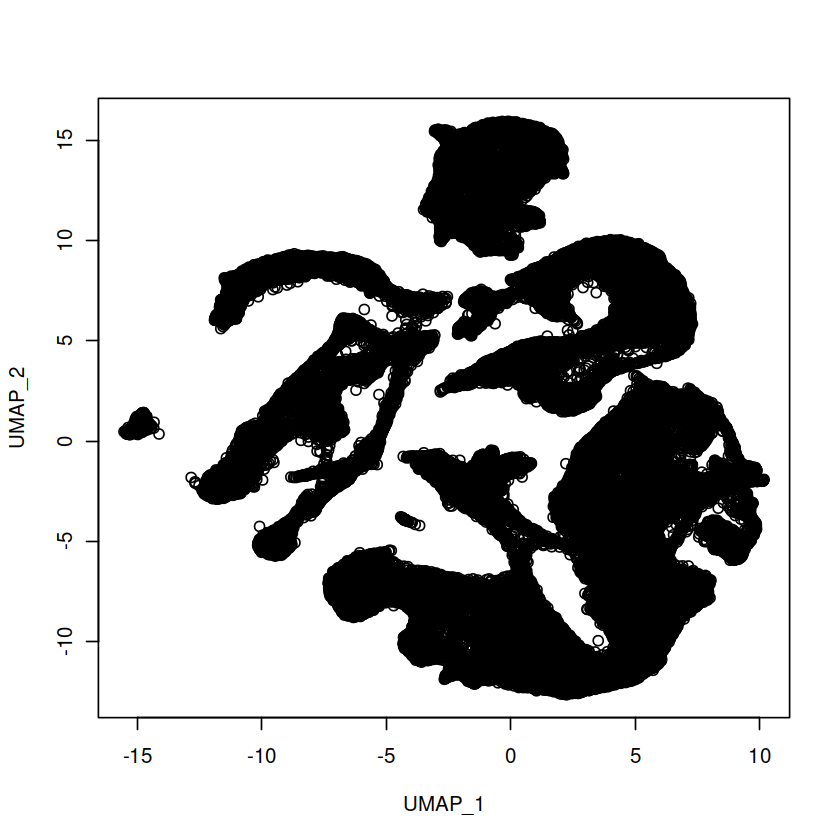

In [11]:
plot(umap.atac)


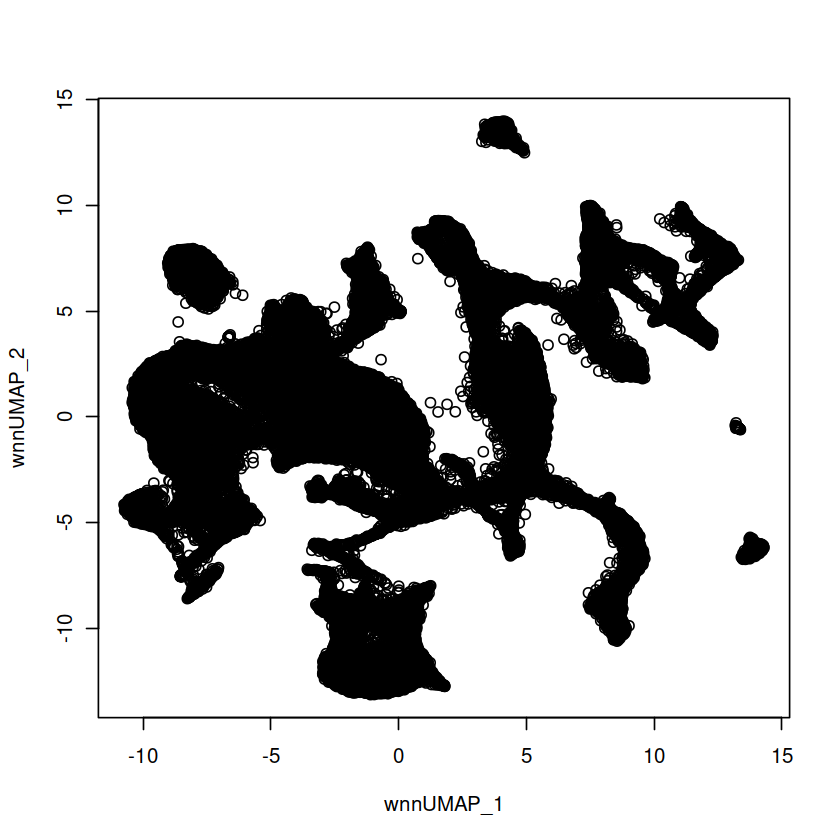

In [19]:
plot(umap.wnn)

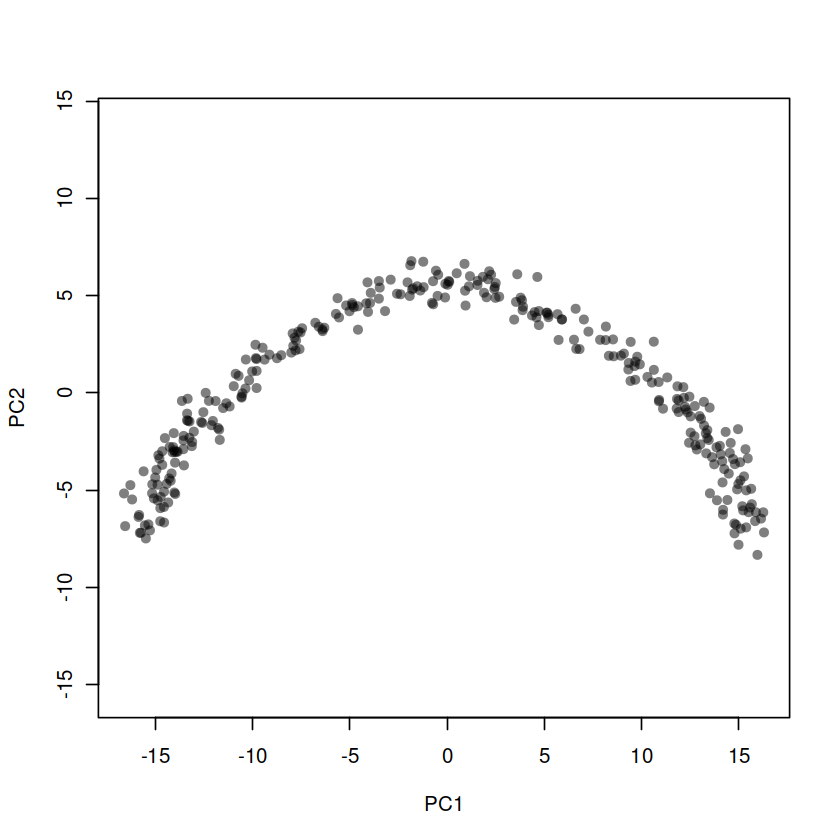

In [8]:
# # dim.reduction
# pca <- prcomp(t(log1p(assays(sce)$norm)), scale. = FALSE)
# rd1 <- pca$x[,1:2]

# plot(rd1, col = rgb(0,0,0,.5), pch=16, asp = 1)

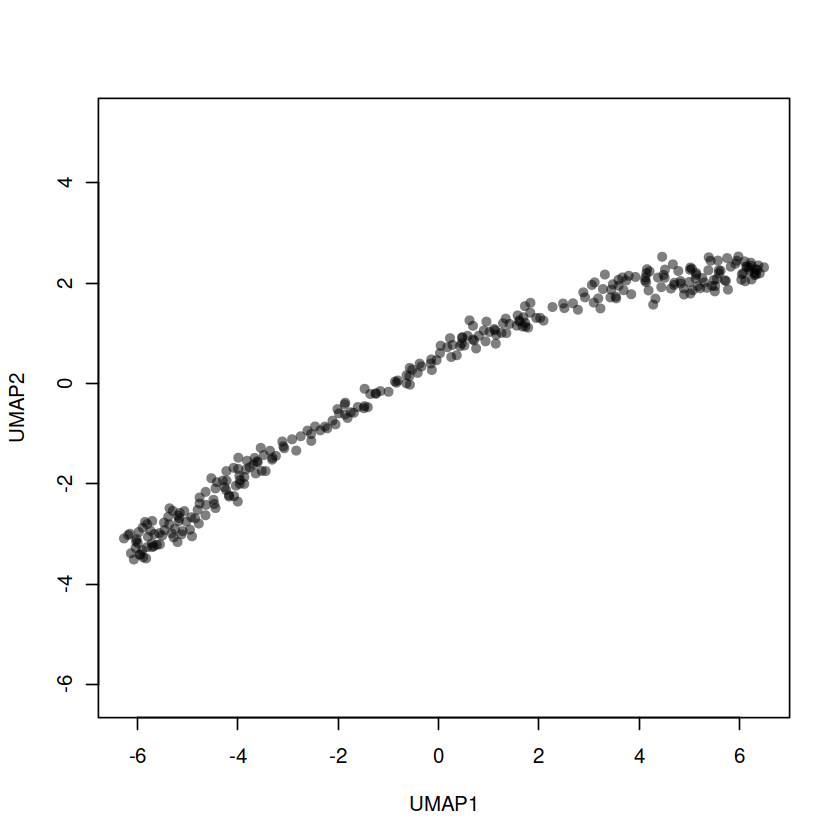

In [10]:
# rd2 <- uwot::umap(t(log1p(assays(sce)$norm)))
# colnames(rd2) <- c('UMAP1', 'UMAP2')

# plot(rd2, col = rgb(0,0,0,.5), pch=16, asp = 1)

We will add both dimensionality reductions to the SingleCellExperiment object, but continue our analysis focusing on the PCA results.

In [15]:
sce

class: SingleCellExperiment 
dim: 32057 95196 
metadata(0):
assays(2): counts logcounts
rownames(32057): ptpn12 phtf2 ... NC-002333.22 NC-002333.11
rowData names(0):
colnames(95196): AAACAGCCACCTAAGC-1_1 AAACAGCCAGGGAGGA-1_1 ...
  TTTGTTGGTGCGCGTA-1_7 TTTGTTGGTTAAGGCC-1_7
colData names(46): orig.ident nCount_RNA ... seurat_clusters ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(3): SCT integrated peaks_integrated

In [20]:
# add UMAP (umap.atac, umap.wnn) for the dim.reduction
reducedDims(sce) <- SimpleList(UMAP.atac = umap.atac,
                               UMAP.wnn = umap.wnn)

Warning message in .check_reddim_names(x, value[[v]], withDimnames = TRUE, vname = sprintf("value[[%s]]", :
“non-NULL 'rownames(value[[2]])' should be the same as 'colnames(x)' for
'reducedDims<-'. This will be an error in the next release of
Bioconductor.”


In [21]:
sce

class: SingleCellExperiment 
dim: 32057 95196 
metadata(0):
assays(2): counts logcounts
rownames(32057): ptpn12 phtf2 ... NC-002333.22 NC-002333.11
rowData names(0):
colnames(95196): AAACAGCCACCTAAGC-1_1 AAACAGCCAGGGAGGA-1_1 ...
  TTTGTTGGTGCGCGTA-1_7 TTTGTTGGTTAAGGCC-1_7
colData names(46): orig.ident nCount_RNA ... seurat_clusters ident
reducedDimNames(2): UMAP.atac UMAP.wnn
mainExpName: RNA
altExpNames(3): SCT integrated peaks_integrated

In [11]:
# reducedDims(sce) <- SimpleList(PCA = rd1, UMAP = rd2)

In [38]:
multiome$global_annotation %>% head()

AAACAGCCACCTAAGC-1_1 AAACAGCCAGGGAGGA-1_1 AAACAGCCATAGACCC-1_1 
         "Epidermal"   "Lateral_Mesoderm"                "PSM" 
AAACATGCAAACTCAT-1_1 AAACATGCAAGGACCA-1_1 AAACATGCAAGGATTA-1_1 
  "Neural_Posterior"    "Neural_Anterior"    "Neural_Anterior"

Warning message in brewer.pal(14, "Set1"):
“n too large, allowed maximum for palette Set1 is 9
Returning the palette you asked for with that many colors
”


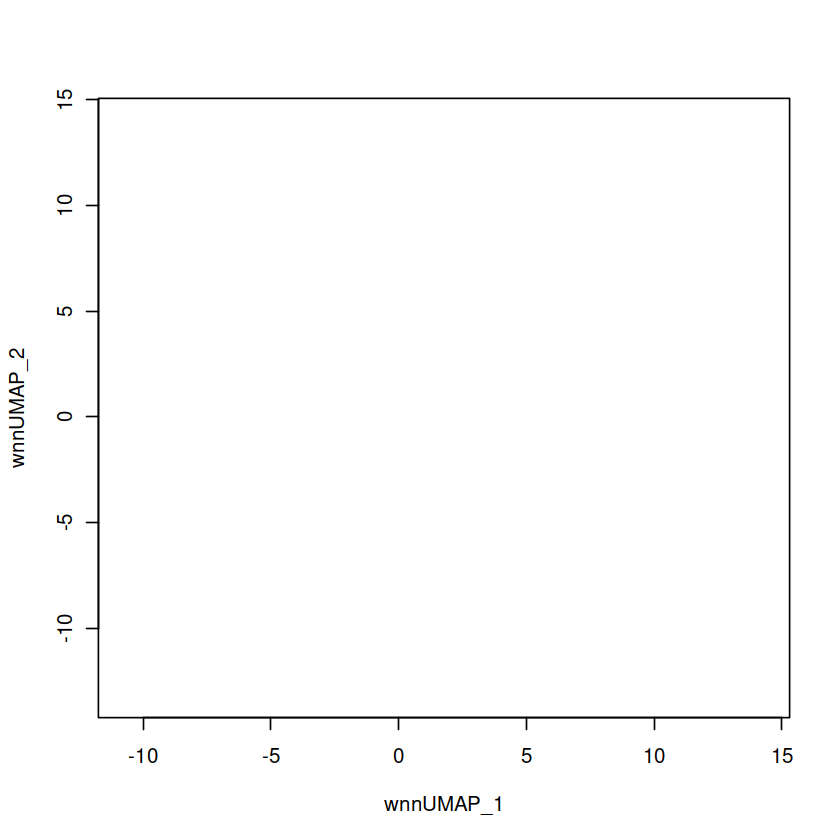

In [47]:
# transfer the celltype annotation (clustering) to the sce object
annotation <- multiome$global_annotation
# colData(sce)$global_annotation <- annotation

library(RColorBrewer)
plot(umap.wnn, col=brewer.pal(14, "Set1")[annotation])

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Set1 is 9
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 17011 rows containing missing values (`geom_point()`).”


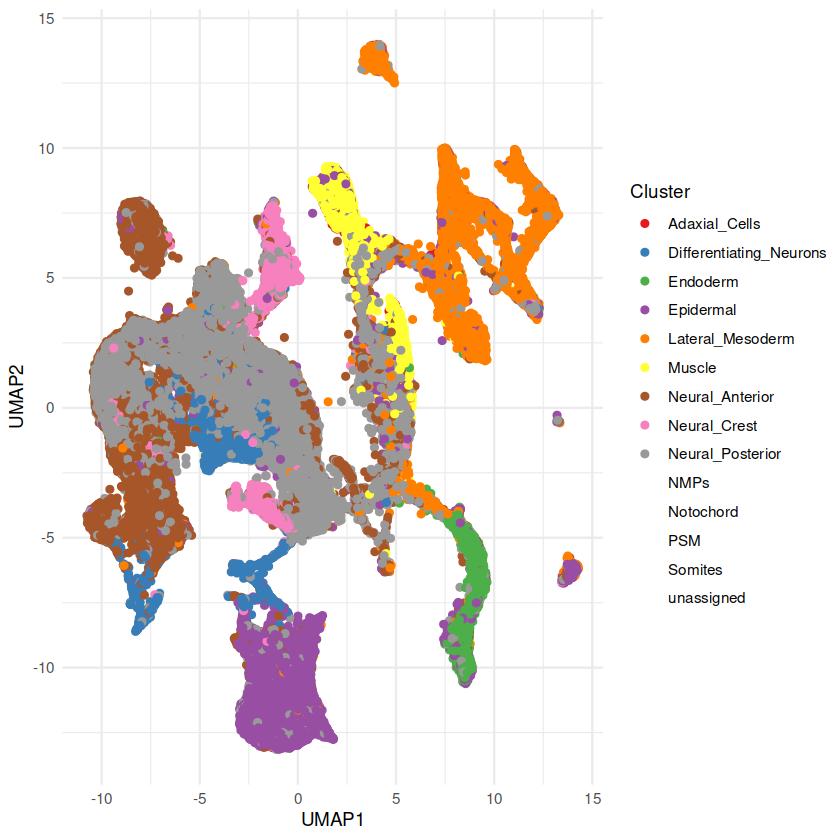

In [52]:
library(ggplot2)
umap_df <- as.data.frame(umap.wnn) # Only if umap.wnn is not already a data frame
names(umap_df) <- c("UMAP1", "UMAP2")
umap_df$Cluster <- factor(annotation)

ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Cluster)) +
  geom_point() +
  scale_color_brewer(palette = "Set1") +
  theme_minimal()

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Set1 is 9
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 17011 rows containing missing values (`geom_point()`).”


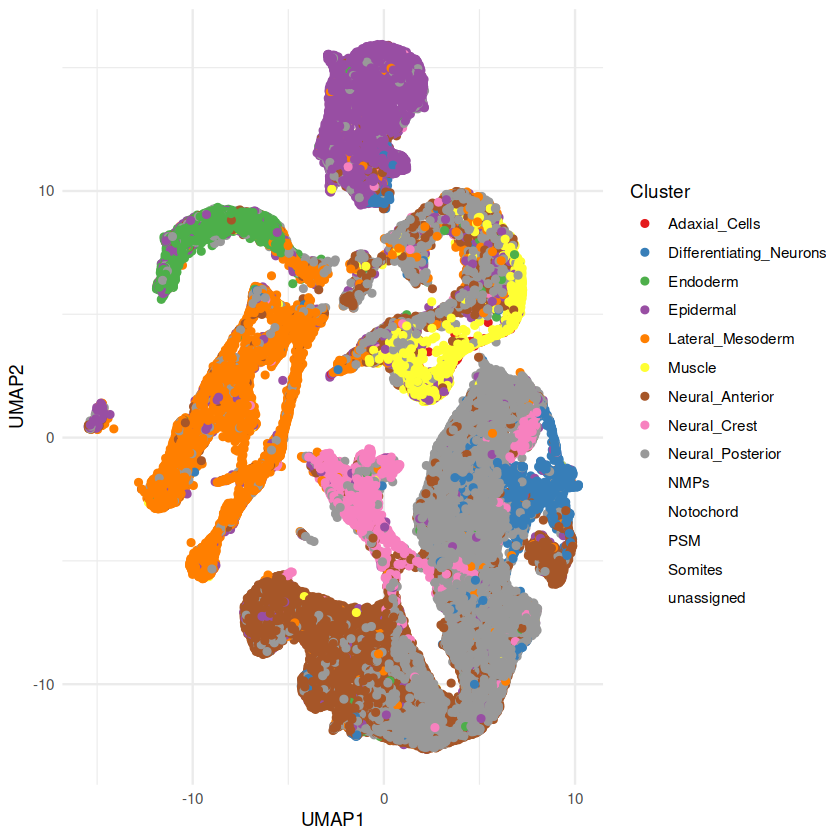

In [53]:
library(ggplot2)
umap_df <- as.data.frame(umap.atac) # Only if umap.wnn is not already a data frame
names(umap_df) <- c("UMAP1", "UMAP2")
umap_df$Cluster <- factor(annotation)

ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Cluster)) +
  geom_point() +
  scale_color_brewer(palette = "Set1") +
  theme_minimal()

In [43]:
multiome$global_annotation %>% unique() %>% length

[1] 14

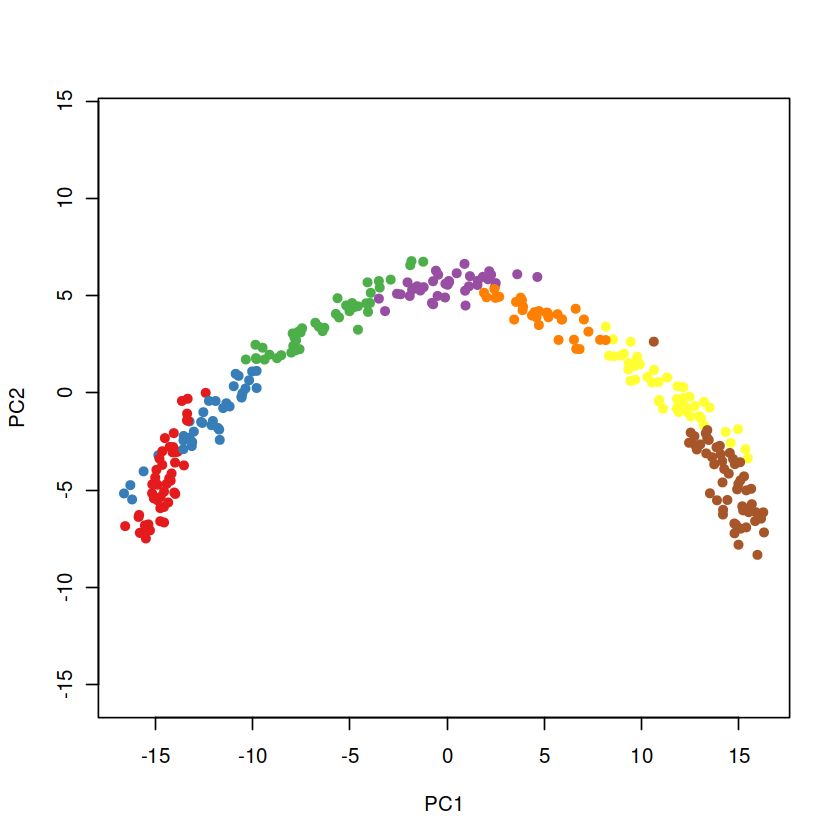

In [13]:
# clustering the cells

cl1 <- Mclust(rd1)$classification
colData(sce)$GMM <- cl1

library(RColorBrewer)
plot(rd1, col = brewer.pal(9,"Set1")[cl1], pch=16, asp = 1)

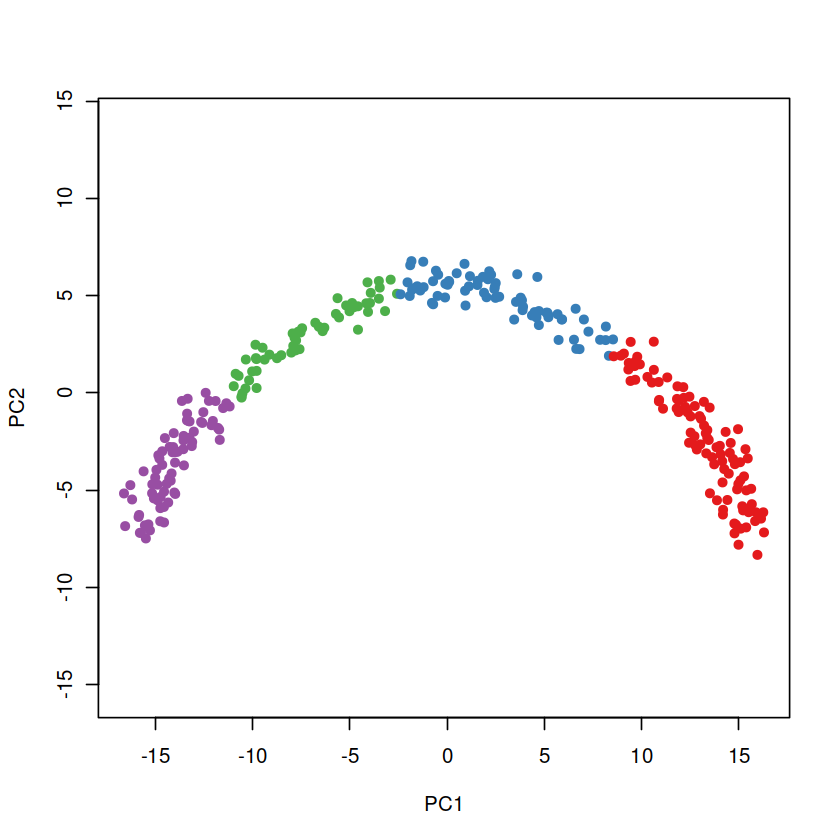

In [14]:
cl2 <- kmeans(rd1, centers = 4)$cluster
colData(sce)$kmeans <- cl2

plot(rd1, col = brewer.pal(9,"Set1")[cl2], pch=16, asp = 1)

In [16]:
library(slingshot, quietly = FALSE)

Loading required package: princurve

Loading required package: TrajectoryUtils



In [54]:
sce

class: SingleCellExperiment 
dim: 32057 95196 
metadata(0):
assays(2): counts logcounts
rownames(32057): ptpn12 phtf2 ... NC-002333.22 NC-002333.11
rowData names(0):
colnames(95196): AAACAGCCACCTAAGC-1_1 AAACAGCCAGGGAGGA-1_1 ...
  TTTGTTGGTGCGCGTA-1_7 TTTGTTGGTTAAGGCC-1_7
colData names(46): orig.ident nCount_RNA ... seurat_clusters ident
reducedDimNames(2): UMAP.atac UMAP.wnn
mainExpName: RNA
altExpNames(3): SCT integrated peaks_integrated

In [55]:
# using Slingshot
sce <- slingshot(sce, clusterLabels = 'global_annotation', reducedDim = 'UMAP.wnn')

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“u

In [56]:
sce

class: SingleCellExperiment 
dim: 32057 95196 
metadata(0):
assays(2): counts logcounts
rownames(32057): ptpn12 phtf2 ... NC-002333.22 NC-002333.11
rowData names(0):
colnames(95196): AAACAGCCACCTAAGC-1_1 AAACAGCCAGGGAGGA-1_1 ...
  TTTGTTGGTGCGCGTA-1_7 TTTGTTGGTTAAGGCC-1_7
colData names(54): orig.ident nCount_RNA ... slingPseudotime_6
  slingPseudotime_7
reducedDimNames(2): UMAP.atac UMAP.wnn
mainExpName: RNA
altExpNames(3): SCT integrated peaks_integrated

In [57]:
summary(sce$slingPseudotime_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00   10.87   19.07   19.01   25.34   45.98   26054 

In [63]:
# colData(sce) %>% head

In [58]:
sce$slingshot@metadata$lineages

$Lineage1
[1] "Lateral_Mesoderm"        "Adaxial_Cells"          
[3] "Muscle"                  "Somites"                
[5] "unassigned"              "Neural_Posterior"       
[7] "Neural_Anterior"         "Differentiating_Neurons"

$Lineage2
[1] "Lateral_Mesoderm" "Adaxial_Cells"    "Muscle"           "Somites"         
[5] "unassigned"       "Neural_Posterior" "Neural_Crest"    

$Lineage3
[1] "Lateral_Mesoderm" "Adaxial_Cells"    "Muscle"           "Somites"         
[5] "unassigned"       "Epidermal"       

$Lineage4
[1] "Lateral_Mesoderm" "Adaxial_Cells"    "Muscle"           "Somites"         
[5] "unassigned"       "PSM"             

$Lineage5
[1] "Lateral_Mesoderm" "Adaxial_Cells"    "Muscle"           "Somites"         
[5] "unassigned"       "Endoderm"        

$Lineage6
[1] "Lateral_Mesoderm" "Adaxial_Cells"    "Muscle"           "Somites"         
[5] "unassigned"       "Notochord"       

$Lineage7
[1] "Lateral_Mesoderm" "Adaxial_Cells"    "Muscle"           "Somites"         
[5] "unassigned"       "NMPs"

In [64]:
# Compute the lineages with pre-defined initial states
annotation <- multiome$global_annotation

lin1 <- getLineages(sce, annotation, start.clus="NMPs")
lin1

Dimensionality reduction not explicitly chosen. Continuing with UMAP.atac

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instea

class: SingleCellExperiment 
dim: 32057 95196 
metadata(0):
assays(2): counts logcounts
rownames(32057): ptpn12 phtf2 ... NC-002333.22 NC-002333.11
rowData names(0):
colnames(95196): AAACAGCCACCTAAGC-1_1 AAACAGCCAGGGAGGA-1_1 ...
  TTTGTTGGTGCGCGTA-1_7 TTTGTTGGTTAAGGCC-1_7
colData names(54): orig.ident nCount_RNA ... slingPseudotime_6
  slingPseudotime_7
reducedDimNames(2): UMAP.atac UMAP.wnn
mainExpName: RNA
altExpNames(3): SCT integrated peaks_integrated

In [ ]:
umap.atac

In [66]:
plot(umap.atac)
lines(SlingshotDataSet(lin1), lwd=3, col="black")

ERROR: Error in as.vector(x, mode = "numeric"): no method for coercing this S4 class to a vector


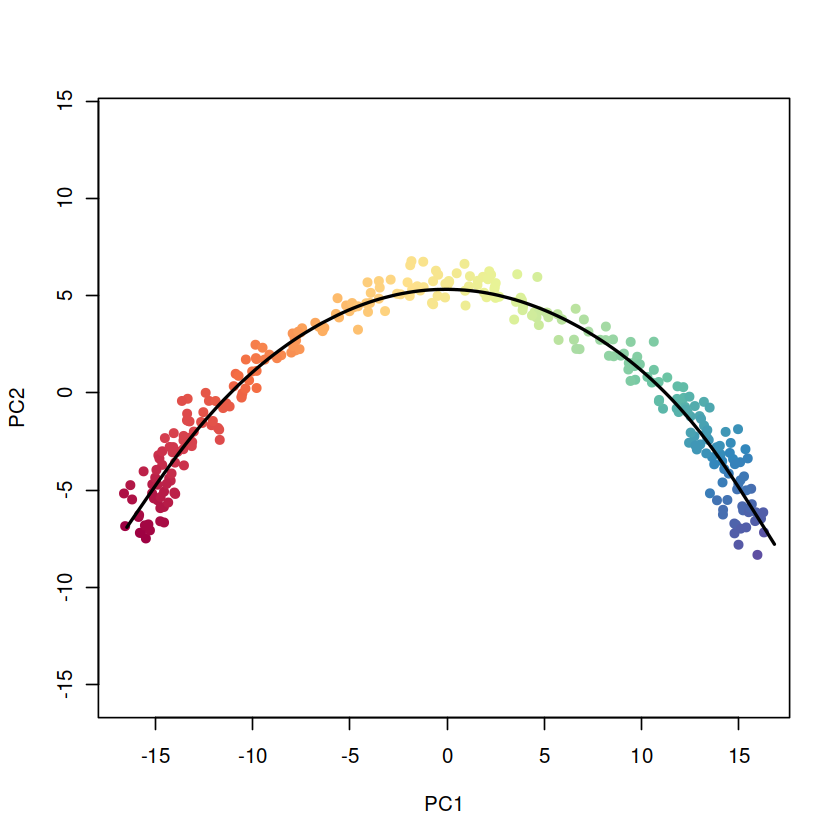

In [21]:
library(grDevices)
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(sce$slingPseudotime_1, breaks=100)]

plot(reducedDims(sce)$PCA, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sce), lwd=2, col='black')

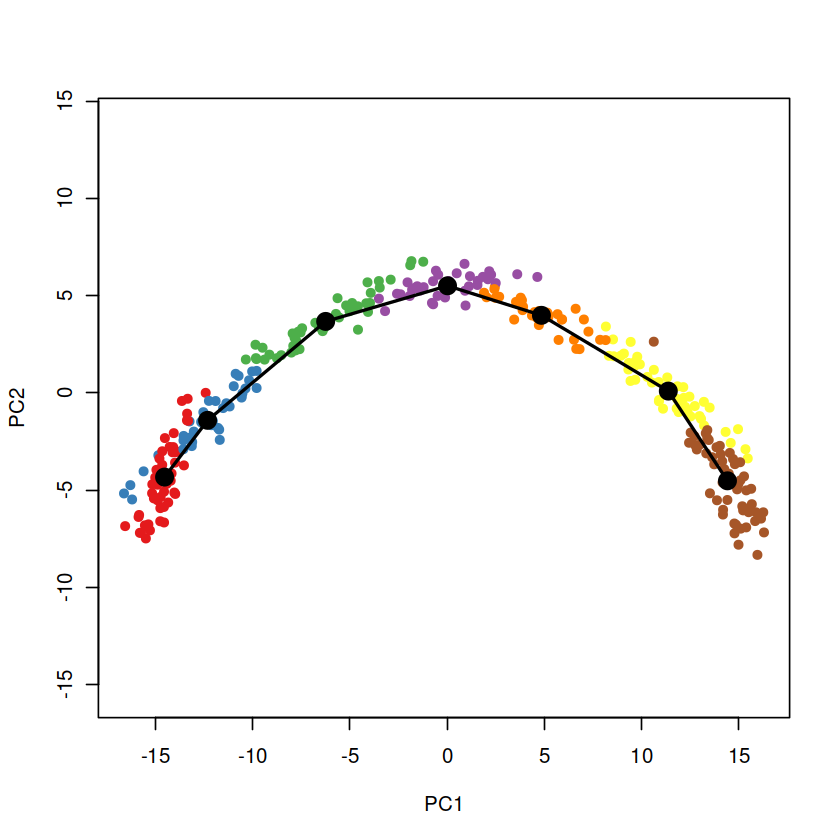

In [22]:
# We can also see how the lineage structure was intially estimated by the cluster-based minimum spanning tree by using the type argument.
plot(reducedDims(sce)$PCA, col = brewer.pal(9,'Set1')[sce$GMM], pch=16, asp = 1)
lines(SlingshotDataSet(sce), lwd=2, type = 'lineages', col = 'black')

## downstream analysis

In [23]:
# Identifying temporally dynamic genes

library(tradeSeq)

# fit negative binomial GAM
sce <- fitGAM(sce)

# test for dynamic expression
ATres <- associationTest(sce)

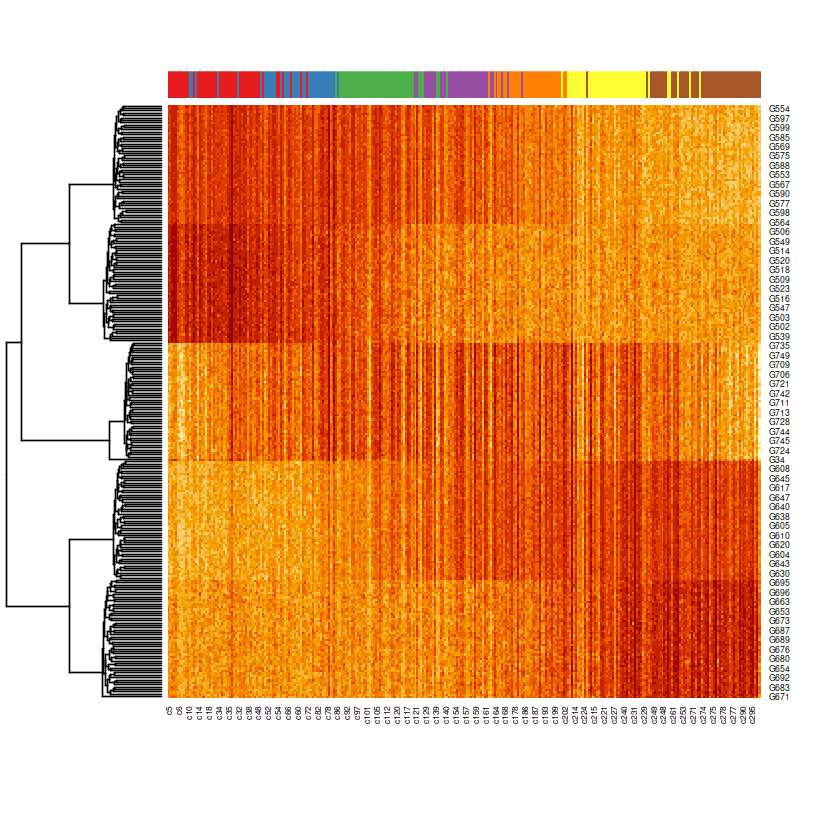

In [24]:
topgenes <- rownames(ATres[order(ATres$pvalue), ])[1:250]
pst.ord <- order(sce$slingPseudotime_1, na.last = NA)
heatdata <- assays(sce)$counts[topgenes, pst.ord]
heatclus <- sce$GMM[pst.ord]

heatmap(log1p(heatdata), Colv = NA,
        ColSideColors = brewer.pal(9,"Set1")[heatclus])

## Advanced

- branching dataset

In [25]:
data("slingshotExample")
# rd means "reduced.dim" - i.e., UMAP
rd <- slingshotExample$rd
# cl means "clustering" - i.e., cell_annotation
cl <- slingshotExample$cl

dim(rd) # data representing cells in a reduced dimensional space

[1] 140   2

In [26]:
lin1 <- getLineages(rd, cl, start.clus = '1')
lin1

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”


class: PseudotimeOrdering 
dim: 140 2 
metadata(3): lineages mst slingParams
pathStats(2): pseudotime weights
cellnames(140): cell-1 cell-2 ... cell-139 cell-140
cellData names(2): reducedDim clusterLabels
pathnames(2): Lineage1 Lineage2
pathData names(0):

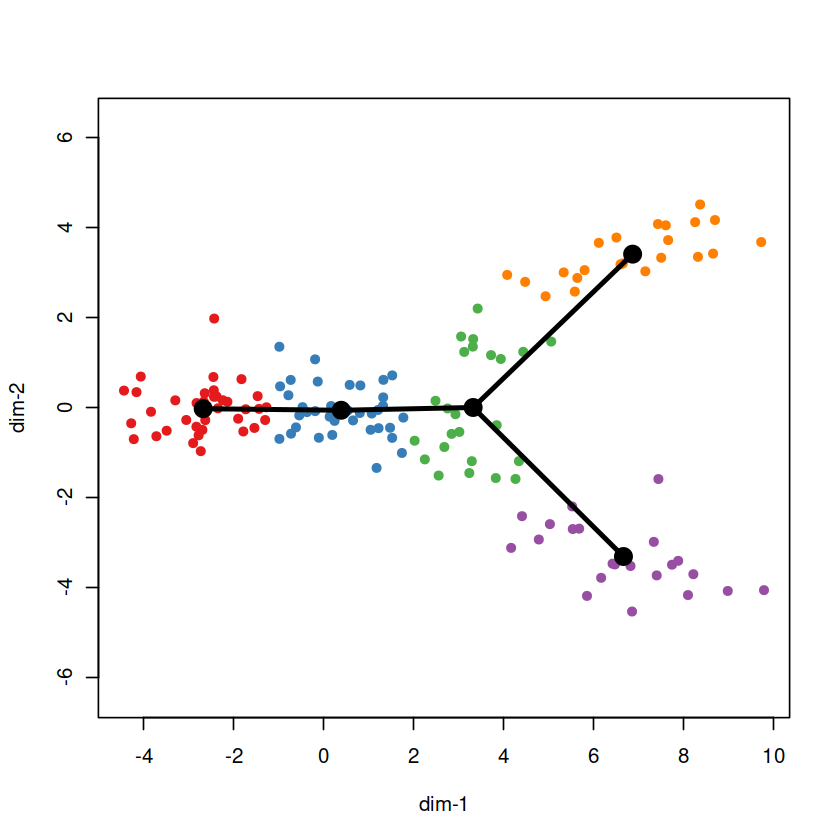

In [32]:
plot(rd, col = brewer.pal(9,"Set1")[cl], asp = 1, pch = 16)
lines(SlingshotDataSet(lin1), lwd = 3, col = 'black')

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE.”


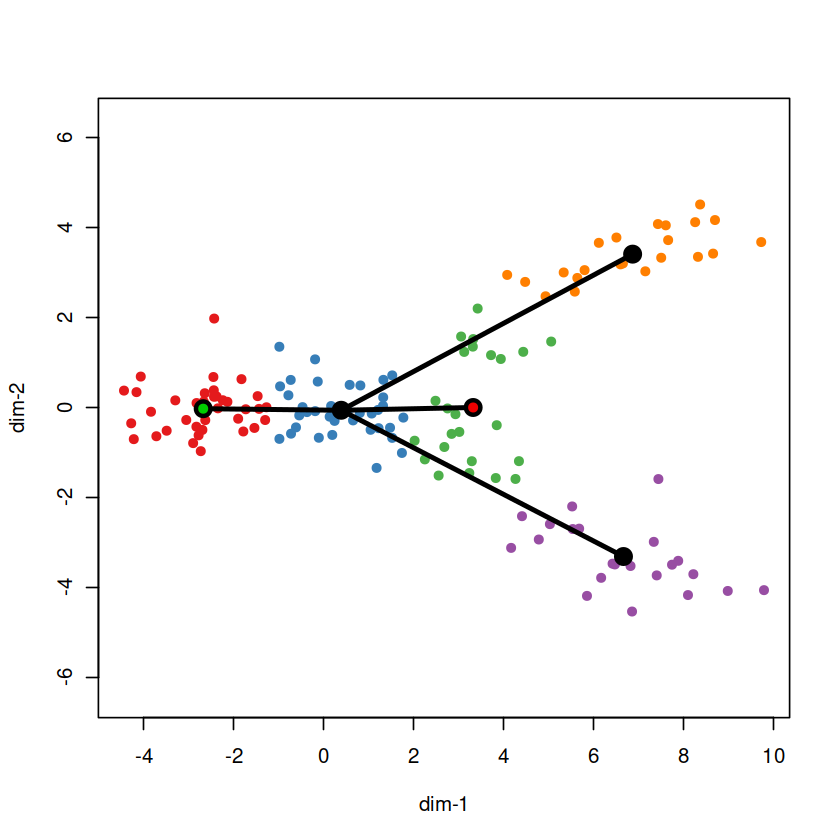

In [33]:
lin2 <- getLineages(rd, cl, start.clus= '1', end.clus = '3')

plot(rd, col = brewer.pal(9,"Set1")[cl], asp = 1, pch = 16)
lines(SlingshotDataSet(lin2), lwd = 3, col = 'black', show.constraints = TRUE)